# Brain age regression using NIDL

In this notebook, we will show how to train a brain age model on OpenBHB (ROI measures) using :

1) standard L1 model
2) more advanced contrastive [Rank-N-Constrast](https://arxiv.org/abs/2210.01189) (RnC) model

During training, the different regression metrics (Pearson-r, $R^2$, RMSE, MAE) will be monitored on the validation set using 'RegressionMetricsCallback' and 'RidgeCVCallback'.

## Install and load the packages

First, we need to install some Python packages used by NIDL (if not already done):

In [ ]:
%pip install -e ../

In [1]:
from pytorch_lightning.loggers import CSVLogger 
from nilearn import plotting, datasets
import nibabel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import seaborn
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
# This library
from nidl.datasets.openbhb import OpenBHB
from nidl.models import DeepRegressor, RnC
from nidl.callbacks import RegressionMetricsCallback, RidgeCVCallback
from nidl.transform import Transform
from nidl.volume.transforms import RandomCutout
from nidl.data.collate import TwoViewsCollateFunction

## Fit L1 model and monitor the validation metrics

In [2]:
# Load the data
dataset_train = OpenBHB("/neurospin/signatures/bd261576/openBHB",
                        target_transforms=lambda y: np.expand_dims(y, axis=-1),
                        target="age", modality="vbm_roi", split="train")
dataset_val = OpenBHB("/neurospin/signatures/bd261576/openBHB",
                      target_transforms=lambda y: np.expand_dims(y, axis=-1),
                      target="age", modality="vbm_roi", split="val")
train_dataloader = DataLoader(dataset_train, batch_size=512, num_workers=10, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=512, num_workers=10, shuffle=False)

In [10]:
# Fit L1
model = DeepRegressor(
    encoder="mlp",
    encoder_kwargs={"layers": [284, 128, 128], "n_embedding": 1},
    loss="l1",
    learning_rate=1e-2,
    callbacks=[RegressionMetricsCallback()],
    logger=CSVLogger("."),
    enable_checkpointing=False,
    max_epochs=20
)
model.fit(train_dataloader, val_dataloader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name     | Type   | Params | Mode 
--------------------------------------------
0 | encoder_ | MLP    | 53.6 K | train
1 | loss_    | L1Loss | 0      | train
--------------------------------------------
53.6 K    Trainable params
0         Non-trainable params
53.6 K    Total params
0.215     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


/home_local/bd261576/miniconda3/envs/nidl/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 19: 100%|██████████| 7/7 [00:07<00:00,  0.99it/s, v_num=1, loss/train=2.990, val_rmse=7.100, val_mae=5.530, val_r2=0.691, val_pearson_r=0.888] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 7/7 [00:07<00:00,  0.99it/s, v_num=1, loss/train=2.990, val_rmse=7.100, val_mae=5.530, val_r2=0.691, val_pearson_r=0.888]


DeepRegressor(
  (encoder_): MLP(
    (mlp): Sequential(
      (0): BasicBlock(
        (linear): Linear(in_features=284, out_features=128, bias=True)
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): BasicBlock(
        (linear): Linear(in_features=128, out_features=128, bias=True)
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (loss_): L1Loss()
)

## Perform prediction and plot the results

In [ ]:
y_pred = model.predict(val_dataloader)

/home_local/bd261576/miniconda3/envs/nidl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:45: Attribute 'callbacks' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['callbacks'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 301.82it/s]


Text(0.5, 0.98, 'Predicted Brain Age vs Chronological Age')

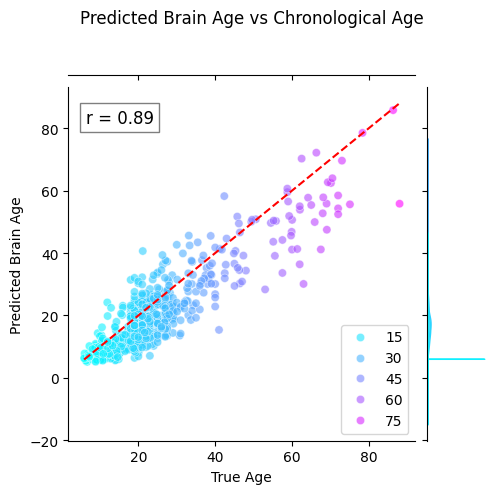

In [ ]:
y_test = [y for (_, y) in dataset_val.samples]
df = pd.DataFrame({"True age": y_test, "Predicted brain age": y_pred.squeeze()})
r_value, _ = pearsonr(y_test, y_pred)
# Create the joint plot with KDE histograms
g = seaborn.jointplot(
    data=df, x="True age", y="Predicted brain age", 
    hue="True age", kind="scatter", alpha=0.6,
    marginal_kws={'fill': True},  # Filled histograms
    palette="cool", height=5
)
g.ax_joint.text(0.05, 0.9, f"r = {r_value:.2f}", transform=g.ax_joint.transAxes, 
                fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
# Reference line y = x
min_age, max_age = np.min(y_test), np.max(y_test)
g.ax_joint.plot([min_age, max_age], [min_age, max_age], 'r--')
g.ax_joint.legend()
g.ax_joint.set_xlabel("True Age")
g.ax_joint.set_ylabel("Predicted Brain Age")
g.figure.suptitle("Predicted Brain Age vs Chronological Age")

## Fit RnC and monitor the validation matrics

In [ ]:
# Load the data
dataset_train = OpenBHB("/neurospin/signatures/bd261576/openBHB",
                        target="age", modality="vbm_roi", split="train")
dataset_val = OpenBHB("/neurospin/signatures/bd261576/openBHB",
                      target="age", modality="vbm_roi", split="val")
dataset_test = OpenBHB("/neurospin/signatures/bd261576/openBHB",
                      target=None, modality="vbm_roi", split="val")

train_dataloader_two_views = DataLoader(dataset_train, batch_size=512, num_workers=10, shuffle=True, 
                              collate_fn=TwoViewsCollateFunction(RandomCutout(num_iterations=10)))
val_dataloader_two_views = DataLoader(dataset_val, batch_size=512, num_workers=10, shuffle=False,
                            collate_fn=TwoViewsCollateFunction(RandomCutout(num_iterations=10)))

train_dataloader = DataLoader(dataset_train, batch_size=512, num_workers=10, shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=512, num_workers=10, shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=512, num_workers=10, shuffle=False)

In [ ]:
# Fit RnC 
rnc = RnC(
    encoder="mlp",
    encoder_kwargs={"layers": [284, 128, 128]},
    n_embedding=16,
    learning_rate=0.1,
    lr_scheduler=None,
    logger=CSVLogger("."),
    max_epochs=20,
    callbacks=[RidgeCVCallback(train_dataloader, val_dataloader)]
)

rnc.fit(train_dataloader_two_views, val_dataloader_two_views)

## Embed the data and plot them 

In [4]:
# Embed the data
embedding = rnc.transform(val_dataloader)

AttributeError: 'list' object has no attribute 'to'

In [ ]:
def prediction_score(z, y):
    def _knn_fitting(x, y):
        knn_model = KNeighborsRegressor()
        knn_model.fit(x, y)
        return knn_model.score(x, y), knn_model.predict(x)
    return _knn_fitting(z, y)

In [ ]:
# PLot the embedding

y_test = [y for (_, y) in dataset_val.samples]
score, y_pred = prediction_score(embedding, y_test)
embedding_2d= TSNE(n_components=2).fit_transform(embedding)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_test, s=10, cmap="cool")
cbar = plt.colorbar(label='Age')
plt.title(f"RnC embedding of OpenBHB, $R^2$={score:.2f}")
plt.axis("off")